<a href="https://colab.research.google.com/github/NBK-code/ARC/blob/main/ARC_SFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install -U transformers accelerate datasets peft bitsandbytes trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 137.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 43.1 MB/s eta 0:00:00


In [ ]:
!pip -q install "flash-attn>=2.6.3" --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 106.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import random, re, math, json, os
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from peft import LoraConfig, PeftModel
from trl import SFTTrainer, SFTConfig
from transformers import BitsAndBytesConfig
from datasets import load_dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

MODEL_ID = "Qwen/Qwen2.5-1.5B-Instruct"
OUT_DIR  = "qwen2p5_1p5b_arc_sft"
os.makedirs(OUT_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [ ]:
if "{% generation %}" not in (tokenizer.chat_template or ""):
    tokenizer.chat_template = """
{% for message in messages %}
{% if message['role'] == 'system' %}
<|im_start|>system
{{ message['content'] }}<|im_end|>
{% elif message['role'] == 'user' %}
<|im_start|>user
{{ message['content'] }}<|im_end|>
{% elif message['role'] == 'assistant' %}
<|im_start|>assistant
{% generation %}{{ message['content'] }}{% endgeneration %}<|im_end|>
{% endif %}
{% endfor %}
{% if add_generation_prompt %}
<|im_start|>assistant
{% endif %}
""".strip()

In [ ]:
def load_jsonl_datasets(train_file, eval_file, num_train=None, num_eval=None, seed=42):
    # Load both train and eval JSONL files together
    dataset = load_dataset(
        "json",
        data_files={
            "train": train_file,
            "eval": eval_file
        }
    )

    # Get train split
    train_data = dataset["train"].shuffle(seed=seed)
    if num_train is not None:   # subset if requested
        train_data = train_data.select(range(num_train))

    # Get eval split
    eval_data = dataset["eval"].shuffle(seed=seed)
    if num_eval is not None:    # subset if requested
        eval_data = eval_data.select(range(num_eval))

    return train_data, eval_data

In [ ]:
# Full dataset
train_data, eval_data = load_jsonl_datasets("sft_train_icl.jsonl", "sft_eval_icl.jsonl")

# Subset dataset (e.g., first 500 training, 100 eval after shuffle)
#train_data, eval_data = load_jsonl_datasets("sft_train_icl.jsonl", "sft_eval_icl.jsonl", num_train=1000, num_eval=100)

print("Train data length: ", len(train_data))
print("Eval data length: ", len(eval_data))
print("\n")
print(train_data[0])

In [ ]:
train_data

Dataset({
    features: ['messages'],
    num_rows: 13902
})

In [ ]:
def add_len(example):
    # teacher-forced text = messages WITH assistant; no generation prompt
    txt = tokenizer.apply_chat_template(example["messages"], add_generation_prompt=False, tokenize=False)
    example["len_full"] = len(tokenizer(txt).input_ids)
    return example

train_len = train_data.map(add_len)
eval_len  = eval_data.map(add_len)

train_lengths = np.array(train_len["len_full"], dtype=int)
eval_lengths  = np.array(eval_len["len_full"], dtype=int)

def summarize(name, arr):
    if len(arr) == 0:
        print(f"{name}: empty"); return
    p = np.percentile(arr, [50, 90, 95, 99, 100]).astype(int)
    print(f"{name}: n={len(arr)} | min={arr.min()} mean={int(arr.mean())} "
          f"median={p[0]} p90={p[1]} p95={p[2]} p99={p[3]} max={p[4]}")

summarize("TRAIN (teacher-forced)", train_lengths)
summarize("EVAL  (teacher-forced)", eval_lengths)

# Optional: keep-rate table for common cutoffs
candidates = [10_000, 12_000, 15_000, 20_000, 22_000, 25_000]
print("\nKeep rates (train):")
for cap in candidates:
    keep = (train_lengths <= cap).mean()
    print(f"  cap={cap:>6}  keep={keep:6.2%}  drop={(1-keep):6.2%}  #drop={int((train_lengths>cap).sum())}")
print("\nKeep rates (eval):")
for cap in candidates:
    keep = (eval_lengths <= cap).mean()
    print(f"  cap={cap:>6}  keep={keep:6.2%}  drop={(1-keep):6.2%}  #drop={int((eval_lengths>cap).sum())}")

# Histogram
binsize = 512
bins = np.arange(0, max(train_lengths.max(initial=0), eval_lengths.max(initial=0)) + binsize, binsize)
plt.figure(figsize=(9, 4.5))
plt.hist(train_lengths, bins=bins, alpha=0.6, label="train")
plt.hist(eval_lengths,  bins=bins, alpha=0.6, label="eval")
for cap in candidates:
    plt.axvline(cap, linestyle="--", linewidth=1)
plt.title("Teacher-forced token lengths")
plt.xlabel("tokens")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
LEN_CAP = 20_000  # e.g., 26.6k

# filter using the precomputed 'len_full'
train_kept = train_len.filter(lambda ex: ex["len_full"] <= LEN_CAP)
eval_kept  = eval_len.filter(lambda ex: ex["len_full"] <= LEN_CAP)

# drop helper column now that we’ve filtered
train_kept = train_kept.remove_columns(["len_full"])
eval_kept  = eval_kept.remove_columns(["len_full"])

# quick report
t_all = np.array(train_len["len_full"], dtype=int)
e_all = np.array(eval_len["len_full"],  dtype=int)
print(f"TRAIN kept {len(train_kept)}/{len(train_len)}  (dropped {(t_all > LEN_CAP).sum()})")
print(f"EVAL  kept {len(eval_kept)}/{len(eval_len)}    (dropped {(e_all > LEN_CAP).sum()})")

In [ ]:
print("Train kept data length: ", len(train_kept))
print("Eval kept data length: ", len(eval_kept))
print("\n")
print(train_kept[0])

Train kept data length:  13860
Eval kept data length:  371


{'messages': [{'role': 'system', 'content': 'You are an ARC puzzle solver. You will be shown a few example input/output pairs and then a new input. Return only the output grid as a list of lists.'}, {'role': 'user', 'content': 'Demonstrations:\n1) INPUT:\n[\n  [8, 8, 8, 8, 8, 8, 0, 8, 8, 0, 8, 8, 8],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [8, 8, 8, 8, 8, 8, 0, 8, 8, 0, 8, 8, 8],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [8, 8, 8, 8, 8, 8, 0, 8, 8, 0, 8, 8, 8]\n]\n   OUTPUT:\n[\n  [8, 8, 8, 8, 8, 8, 0, 2, 2, 0, 8, 8, 8],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [4, 4, 4, 4, 4, 4, 0, 6, 6, 0, 3, 3, 3],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [8, 8, 8, 8, 8, 8, 0, 1, 1, 0, 8, 8, 8]\n]\n2) INPUT:\n[\n  [9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9],\n  [9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9],\n  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [ ]:
SEED = 42
train_kept = train_kept.shuffle(seed=SEED)
eval_kept  = eval_kept.shuffle(seed=SEED)

In [ ]:
peft_config = LoraConfig(
    r=8, lora_alpha=16, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM",
    target_modules=["q_proj","k_proj","v_proj","o_proj"],
)

In [ ]:
# Build a proper bnb config (use torch dtypes, not strings)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=(
        torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
    ),
)

sft_config = SFTConfig(
    output_dir=OUT_DIR,
    num_train_epochs=1.0,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    logging_steps=20,
    save_steps=0,
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    bf16=torch.cuda.is_bf16_supported(),
    fp16=not torch.cuda.is_bf16_supported() and torch.cuda.is_available(),
    gradient_checkpointing=True,
    max_length=20500,
    packing=False,
    assistant_only_loss=True,
    eos_token="<|im_end|>",
    dataset_num_proc=4,
    model_init_kwargs=dict(
        device_map="auto",
        quantization_config=bnb_config,
        torch_dtype="auto",
        attn_implementation="flash_attention_2",
        low_cpu_mem_usage=True,
    ),
    report_to="none",
    logging_dir=f"{OUT_DIR}/logs",
)

from transformers import TrainerCallback

class PeriodicEvalCallback(TrainerCallback):
    def __init__(self, eval_every=200):
        self.eval_every = eval_every
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step > 0 and state.global_step % self.eval_every == 0:
            control.should_evaluate = True   # ask Trainer to run evaluate()
        return control

trainer = SFTTrainer(
    model=MODEL_ID,
    args=sft_config,
    train_dataset=train_kept,
    #eval_dataset=eval_kept,
    processing_class=tokenizer,
    peft_config=peft_config,
    #callbacks=[PeriodicEvalCallback(eval_every=100)],
    callbacks=[],
)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
trainer.train()
trainer.save_model()
tokenizer.save_pretrained(OUT_DIR)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.
Casting fp32 inputs back to torch.bfloat16 for flash-attn compatibility.


Step,Training Loss
20,0.083200
40,0.103300
60,0.085000
80,0.059600
100,0.089500
120,0.065300
140,0.072600
160,0.082000
180,0.080800
200,0.086900


('qwen2p5_1p5b_arc_sft/tokenizer_config.json',
 'qwen2p5_1p5b_arc_sft/special_tokens_map.json',
 'qwen2p5_1p5b_arc_sft/chat_template.jinja',
 'qwen2p5_1p5b_arc_sft/vocab.json',
 'qwen2p5_1p5b_arc_sft/merges.txt',
 'qwen2p5_1p5b_arc_sft/added_tokens.json',
 'qwen2p5_1p5b_arc_sft/tokenizer.json')

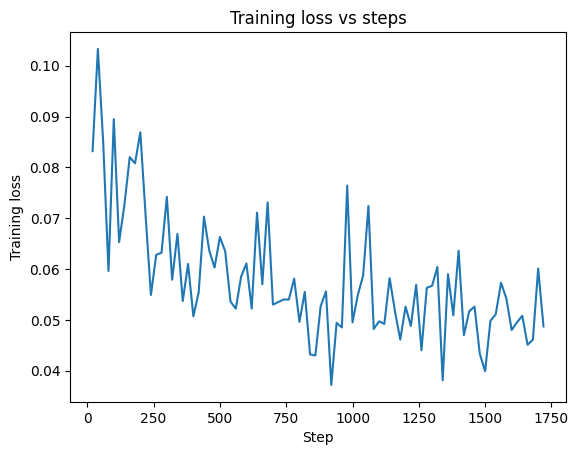

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(trainer.state.log_history)
train_logs = hist[hist["loss"].notna()][["step","loss","learning_rate"]].copy()
plt.figure()
plt.plot(train_logs["step"], train_logs["loss"])
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.title("Training loss vs steps")
plt.show()

In [ ]:
import os, time, json, shutil, torch
from pathlib import Path

# 1) Pick output paths
timestamp   = time.strftime("%Y%m%d-%H%M%S")
OUT_DIR     = globals().get("OUT_DIR", "ckpts/qwen15b_arc_sft")
ADAPTER_DIR = f"{OUT_DIR}/lora_{timestamp}"
Path(ADAPTER_DIR).mkdir(parents=True, exist_ok=True)

# 2) Save LoRA adapter + tokenizer
trainer.model.save_pretrained(ADAPTER_DIR)   # adapter_model.safetensors + adapter_config.json
tokenizer.save_pretrained(ADAPTER_DIR)

# record base + a tiny readme
base_id = globals().get("MODEL_ID", "Qwen/Qwen2.5-1.5B-Instruct")
with open(os.path.join(ADAPTER_DIR, "BASE_MODEL.txt"), "w") as f:
    f.write(base_id + "\n")

print("✅ Saved LoRA adapter to:", ADAPTER_DIR)

# 3) Zip and download (fastest way out of Colab)
!zip -rq lora_adapter.zip "$ADAPTER_DIR"

from google.colab import files
files.download("lora_adapter.zip")

✅ Saved LoRA adapter to: qwen2p5_1p5b_arc_sft/lora_20250907-095118


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
OUT_DIR

'qwen2p5_1p5b_arc_sft'

In [ ]:
!zip -r my_folder.zip "/content/qwen2p5_1p5b_arc_sft"
from google.colab import files
files.download("my_folder.zip")

  adding: content/qwen2p5_1p5b_arc_sft/ (stored 0%)
  adding: content/qwen2p5_1p5b_arc_sft/tokenizer.json (deflated 81%)
  adding: content/qwen2p5_1p5b_arc_sft/adapter_config.json (deflated 56%)
  adding: content/qwen2p5_1p5b_arc_sft/merges.txt (deflated 57%)
  adding: content/qwen2p5_1p5b_arc_sft/checkpoint-1733/ (stored 0%)
  adding: content/qwen2p5_1p5b_arc_sft/checkpoint-1733/tokenizer.json (deflated 81%)
  adding: content/qwen2p5_1p5b_arc_sft/checkpoint-1733/adapter_config.json (deflated 56%)
  adding: content/qwen2p5_1p5b_arc_sft/checkpoint-1733/merges.txt (deflated 57%)
  adding: content/qwen2p5_1p5b_arc_sft/checkpoint-1733/optimizer.pt (deflated 8%)
  adding: content/qwen2p5_1p5b_arc_sft/checkpoint-1733/trainer_state.json (deflated 77%)
  adding: content/qwen2p5_1p5b_arc_sft/checkpoint-1733/training_args.bin (deflated 53%)
  adding: content/qwen2p5_1p5b_arc_sft/checkpoint-1733/chat_template.jinja (deflated 62%)
  adding: content/qwen2p5_1p5b_arc_sft/checkpoint-1733/README.md (d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>